# CSGY 6953 Deep Learning Final Project
In this project, we will implement a dual-encoder model for image search. Our model will be trained so that it embeds both images and texts into the same space, and importantly, maps relevant data to be close each other in the embedding space. This will be done by developing two encoders, one for image processing and the other for text encoding, and training them by a similarity-based loss function.<br>
<br>
In this note book, we study the effect of the size of the embedding space.

## 1. Preparation
As always, prepare the dataset for the training.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import sys

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
with open(f"drive/My Drive/finalproj/data/dataset.pkl", "rb") as f:
    dataset = pickle.load(f)

In [ ]:
# Split them into training and test sets.
train_pct = 0.7
threshold = int(len(dataset["images"]) * train_pct)
train_images = dataset["images"][:threshold]
train_texts = dataset["texts"][:threshold * 10]
test_images = dataset["images"][threshold:]
test_texts = dataset["texts"][threshold * 10:]
print(f"Training images: ", len(train_images))
print(f"Training texts: ", len(train_texts))
print(f"Test images: ", len(test_images))
print(f"Test texts: ", len(test_texts))

Training images:  3150
Training texts:  31500
Test images:  1350
Test texts:  13500


In [ ]:
import torch
from torch.utils.data import DataLoader

In [ ]:
# These are the libraries we developed from scratch for this project.
sys.path.append("drive/My Drive/finalproj")
import EncoderHeads, Dataset, utils

Please see https://github.com/pypa/pip/issues/5599 for advice on fixing the underlying issue.
To avoid this problem you can invoke Python with '-m pip' instead of running pip directly.
Please see https://github.com/pypa/pip/issues/5599 for advice on fixing the underlying issue.
To avoid this problem you can invoke Python with '-m pip' instead of running pip directly.
Please see https://github.com/pypa/pip/issues/5599 for advice on fixing the underlying issue.
To avoid this problem you can invoke Python with '-m pip' instead of running pip directly.


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("The device is " + device.type + ".")

The device is cuda.


In [ ]:
max_len = 60 # Recommend: 46 for GloVe, 60 for BERT (though the maximum is 146)
image_encoder_model = "InceptionV3"
text_encoder_model = "BERT"
image_head_model = "FC"
text_head_model = "FC"

TrainingDataset = Dataset.DualEncoderDataset(train_images, train_texts, device, image_encoder_model, text_encoder_model, max_len=max_len, neg_rate=4)
TestDataset = Dataset.DualEncoderDataset(test_images, test_texts, device, image_encoder_model, text_encoder_model, max_len=max_len, neg_rate=4)
TrainingDataset.print_num_params()


Preprocessing image data...


/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/inception_v3_google-0cc3c7bd.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-0cc3c7bd.pth


  0%|          | 0.00/104M [00:00<?, ?B/s]

100%|██████████| 99/99 [00:21<00:00,  4.56it/s]


Preprocessing text data...


Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

100%|██████████| 985/985 [00:51<00:00, 19.11it/s]



Preprocessing image data...


100%|██████████| 43/43 [00:06<00:00,  6.82it/s]


Preprocessing text data...


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 422/422 [00:21<00:00, 19.92it/s]


=== Image Encoder ===
  Pretrained Parameters: 25,112,264

=== Text Encoder ===
  Pretrained Parameters: 109,482,240


## 2. Random Search
First, we choose different dimensionality for embedding space, train the model for 20 epochs, and compare the test loss.

In [ ]:
epochs = 20
batch_size = 128
trainloader = DataLoader(TrainingDataset, batch_size=batch_size, shuffle=True)
testloader = DataLoader(TestDataset, batch_size=batch_size, shuffle=True)

embed_dim_pool = [16, 32, 64, 128, 256]
train_losses, eval_losses, eval_loss_decomposed = [], [], []

for embed_dim in embed_dim_pool:
    print(f"\nEmbedding Space Dimensionality = {embed_dim:.0f}")
    image_head = EncoderHeads.EncoderHead(image_head_model, TrainingDataset.image_encoder_output_size, embed_dim).to(device)
    text_head = EncoderHeads.EncoderHead(text_head_model, TrainingDataset.text_encoder_output_size, embed_dim).to(device)
    criterion = torch.nn.CosineEmbeddingLoss(margin=0.1, reduction='sum') # Recipe 1M+ paper sets margin=0.1.
    image_optimizer = torch.optim.Adam(image_head.parameters(), lr=0.0005)
    text_optimizer = torch.optim.Adam(text_head.parameters(), lr=0.0005)

    train_loss, eval_loss = [], []
    for epoch in range(epochs):
        trainloss = utils.train(trainloader, image_head, text_head, image_optimizer, text_optimizer, criterion)
        train_loss.append(trainloss)
        evalloss, _ = utils.eval(testloader, image_head, text_head, criterion)
        eval_loss.append(evalloss)
        if (epoch + 1) % 5 == 0:
            print(f"   Epoch: {epoch + 1} | Training loss: {trainloss:.4f} | Test loss: {evalloss:.4f}")
    pos_loss, neg_loss = utils.eval_decomposed(testloader, image_head, text_head)
    
    train_losses.append(train_loss)
    eval_losses.append(eval_loss)
    eval_loss_decomposed.append([pos_loss, neg_loss])
    emb_loss = {"train": train_losses, "test": eval_losses, "embed_dim": embed_dim_pool}
    with open(f"drive/My Drive/finalproj/emb_loss.pkl", "wb") as f:
        pickle.dump(emb_loss, f)


Embedding Space Dimensionality = 16
   Epoch: 5 | Training loss: 0.1707 | Test loss: 0.1753
   Epoch: 10 | Training loss: 0.1618 | Test loss: 0.1707
   Epoch: 15 | Training loss: 0.1473 | Test loss: 0.1642
   Epoch: 20 | Training loss: 0.1272 | Test loss: 0.1565

Embedding Space Dimensionality = 32
   Epoch: 5 | Training loss: 0.0779 | Test loss: 0.1220
   Epoch: 10 | Training loss: 0.0615 | Test loss: 0.1190
   Epoch: 15 | Training loss: 0.0540 | Test loss: 0.1178
   Epoch: 20 | Training loss: 0.0495 | Test loss: 0.1176

Embedding Space Dimensionality = 64
   Epoch: 5 | Training loss: 0.0804 | Test loss: 0.1283
   Epoch: 10 | Training loss: 0.0634 | Test loss: 0.1236
   Epoch: 15 | Training loss: 0.0561 | Test loss: 0.1220
   Epoch: 20 | Training loss: 0.0520 | Test loss: 0.1196

Embedding Space Dimensionality = 128
   Epoch: 5 | Training loss: 0.0829 | Test loss: 0.1274
   Epoch: 10 | Training loss: 0.0653 | Test loss: 0.1212
   Epoch: 15 | Training loss: 0.0584 | Test loss: 0.1220


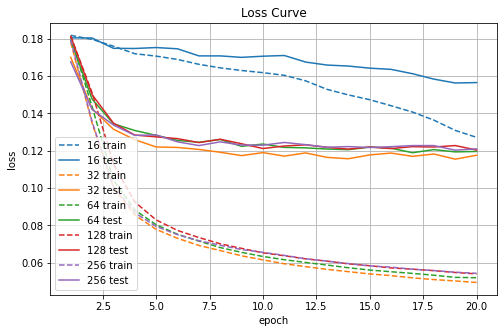

In [ ]:
plt.figure(figsize=(8,5))
for i in range(len(embed_dim_pool)):
    plt.plot(np.arange(1, epochs + 1), train_losses[i], label=f"{embed_dim_pool[i]:.0f} train", color=plt.cm.tab10(i), linestyle="dashed")
    plt.plot(np.arange(1, epochs + 1), eval_losses[i], label=f"{embed_dim_pool[i]:.0f} test", color=plt.cm.tab10(i))
plt.title(f"Loss Curve")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.grid()
plt.legend()
plt.savefig("embed_dim.png", bbox_inches="tight")
plt.show()

The plot above suggests that 16 is too small for the embedding space dimensionality. However, having more dimensionality than 32 doesn't improves the model performance in terms of the test loss. So, as the next step, do the search again in the range 16-32. Due to the limited computational resource, we decrease the epochs to 10 for this.

In [ ]:
epochs = 10
batch_size = 128
trainloader = DataLoader(TrainingDataset, batch_size=batch_size, shuffle=True)
testloader = DataLoader(TestDataset, batch_size=batch_size, shuffle=True)

embed_dim_pool = [16, 17, 18, 19, 20, 21, 22]
train_losses, eval_losses, eval_loss_decomposed, image_MedR = [], [], [], []

for embed_dim in embed_dim_pool:
    print(f"\nEmbedding Space Dimensionality = {embed_dim:.0f}")
    image_head = EncoderHeads.EncoderHead(image_head_model, TrainingDataset.image_encoder_output_size, embed_dim).to(device)
    text_head = EncoderHeads.EncoderHead(text_head_model, TrainingDataset.text_encoder_output_size, embed_dim).to(device)
    criterion = torch.nn.CosineEmbeddingLoss(margin=0.1, reduction='sum') # Recipe 1M+ paper sets margin=0.1.
    image_optimizer = torch.optim.Adam(image_head.parameters(), lr=0.0005)
    text_optimizer = torch.optim.Adam(text_head.parameters(), lr=0.0005)

    train_loss, eval_loss = [], []
    for epoch in range(epochs):
        trainloss = utils.train(trainloader, image_head, text_head, image_optimizer, text_optimizer, criterion)
        train_loss.append(trainloss)
        evalloss, _ = utils.eval(testloader, image_head, text_head, criterion)
        eval_loss.append(evalloss)
        if (epoch + 1) % 5 == 0:
            print(f"   Epoch: {epoch + 1} | Training loss: {trainloss:.4f} | Test loss: {evalloss:.4f}")
    pos_loss, neg_loss = utils.eval_decomposed(testloader, image_head, text_head)
    _, sim_mat = utils.eval(testloader, image_head, text_head, criterion, only_loss=False)
    MedR = utils.getMedR(testloader, sim_mat)
    
    train_losses.append(train_loss)
    eval_losses.append(eval_loss)
    eval_loss_decomposed.append([pos_loss, neg_loss])
    image_MedR.append(MedR["image"])
    emb_loss = {"train": train_losses, "test": eval_losses, "embed_dim": embed_dim_pool, "MedR": image_MedR}
    with open(f"drive/My Drive/finalproj/emb_loss2.pkl", "wb") as f:
        pickle.dump(emb_loss, f)


Embedding Space Dimensionality = 16
   Epoch: 5 | Training loss: 0.0870 | Test loss: 0.1311
   Epoch: 10 | Training loss: 0.0676 | Test loss: 0.1241

Embedding Space Dimensionality = 17
   Epoch: 5 | Training loss: 0.1270 | Test loss: 0.1485
   Epoch: 10 | Training loss: 0.0821 | Test loss: 0.1336

Embedding Space Dimensionality = 18
   Epoch: 5 | Training loss: 0.1034 | Test loss: 0.1370
   Epoch: 10 | Training loss: 0.0734 | Test loss: 0.1283

Embedding Space Dimensionality = 19
   Epoch: 5 | Training loss: 0.1534 | Test loss: 0.1614
   Epoch: 10 | Training loss: 0.0887 | Test loss: 0.1346

Embedding Space Dimensionality = 20
   Epoch: 5 | Training loss: 0.0886 | Test loss: 0.1300
   Epoch: 10 | Training loss: 0.0672 | Test loss: 0.1233

Embedding Space Dimensionality = 21
   Epoch: 5 | Training loss: 0.0860 | Test loss: 0.1287
   Epoch: 10 | Training loss: 0.0663 | Test loss: 0.1218

Embedding Space Dimensionality = 22
   Epoch: 5 | Training loss: 0.1136 | Test loss: 0.1436
   Epoc

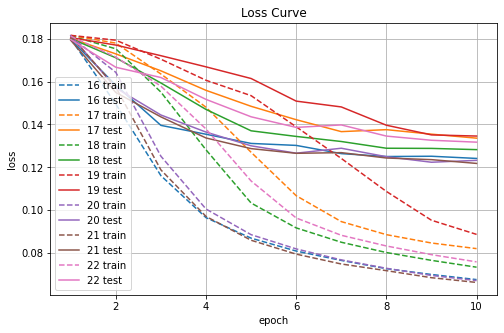

In [ ]:
plt.figure(figsize=(8,5))
for i in range(len(embed_dim_pool)):
    plt.plot(np.arange(1, epochs + 1), train_losses[i], label=f"{embed_dim_pool[i]:.0f} train", color=plt.cm.tab10(i), linestyle="dashed")
    plt.plot(np.arange(1, epochs + 1), eval_losses[i], label=f"{embed_dim_pool[i]:.0f} test", color=plt.cm.tab10(i))
plt.title(f"Loss Curve")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.grid()
plt.legend()
plt.savefig("embed_dim_2.png", bbox_inches="tight")
plt.show()

## 3. Observation
From the experiment above, we see the dimensionality smaller than or equal to 18 may not be enough for all of our data set to project into. However, the dimensionality more than 19 results in similar test loss. These results are also comparable to our base setting of 256 dimensional space. On the other hand, setting larger dimensionality doesn't seem to lead into worse performance.